# Lab 05 Data Preprocessing

## Overview

In this lab, we'll continue building on our data understanding by addressing issues that prevent meaningful analysis — namely, data quality and structure.

We remain within the CRISP-DM framework, moving from "Data Understanding" to "Data Preparation." Preprocessing is a key step in this phase, helping us to:

Handle missing values and inconsistent formats
Identify and manage outliers
Create features that better reflect business behavior
Ensure our data is suitable for clustering and other modeling tasks
Without preprocessing, any clustering results would be unreliable or misleading. Clean, consistent data is essential for drawing valid business insights.

In [1]:
# Remember: library imports are ALWAYS at the top of the script, no exceptions!
import sqlite3
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

from itertools import product
from scipy.stats import skewnorm

from datetime import datetime
from sklearn.impute import KNNImputer

# for better resolution plots
%config InlineBackend.figure_format = 'retina' # optionally, you can change 'svg' to 'retina'

# Setting seaborn style
sns.set()

# Context
The data we will be using through the pratical classes comes from a small relational database whose schema can be seen below:
![alt text](../figures/schema.png "Relation database schema")

# Reading the Data

In [2]:
# path to database
my_path = os.path.join("..", "data", "datamining.db")

# connect to the database
conn = sqlite3.connect(my_path)

# the query
query = """
select
    age, 
    income, 
    frq, 
    rcn, 
    mnt, 
    clothes, 
    kitchen, 
    small_appliances, 
    toys, 
    house_keeping,
    dependents, 
    per_net_purchase,
    g.gender, 
    e.education, 
    m.status, 
    r.description
from customers as c
    join genders as g on g.id = c.gender_id
    join education_levels as e on e.id = c.education_id
    join marital_status as m on m.id = c.marital_status_id
    join recommendations as r on r.id = c.recommendation_id
order by c.id;
"""

df = pd.read_sql_query(query, conn)

## Make a copy of your original dataset

why?

In [3]:
df_original = df.copy()

# Metadata
- *id* - The unique identifier of the customer
- *age* - The year of birht of the customer
- *income* - The income of the customer
- *frq* - Frequency: number of purchases made by the customer
- *rcn* - Recency: number of days since last customer purchase
- *mnt* - Monetary: amount of € spent by the customer in purchases
- *clothes* - Number of clothes items purchased by the customer
- *kitchen* - Number of kitchen items purchased by the customer
- *small_appliances* - Number of small_appliances items purchased by the customer
- *toys* - Number of toys items purchased by the customer
- *house_keeping* - Number of house_keeping items purchased by the customer
- *dependents* - Binary. Whether or not the customer has dependents
- *per_net_purchase* - Percentage of purchases made online
- *education* - Education level of the customer
- *status* - Marital status of the customer
- *gender* - Gender of the customer
- *description* - Last customer's recommendation description

# Problems:
- Duplicates?
- Data types?
- Missing values?
- Strange values?
- Descriptive statistics?

### Take a closer look and point out possible problems:

(hint: a missing values in pandas is represented with a NaN value)

## Replicating modifications from previous notebook

In [4]:
# replace "" by nans
df.replace("", np.nan, inplace=True)

# count of missing values
df.isna().sum()

/var/folders/ds/6m4qg1b17k759smww2lx6_7w0000gn/T/ipykernel_2203/3385904135.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace("", np.nan, inplace=True)


age                   0
income               46
frq                   0
rcn                   0
mnt                   0
clothes               0
kitchen               0
small_appliances      0
toys                  0
house_keeping         0
dependents          282
per_net_purchase      0
gender                0
education            47
status              177
description           0
dtype: int64

In [5]:
# fix wrong dtypes
df.dependents = df.dependents.astype("boolean")  # converting to "boolean" over "bool" allows preservation of NaNs

In [6]:
# check dataset data types again
df.dtypes

age                   int64
income              float64
frq                   int64
rcn                   int64
mnt                   int64
clothes               int64
kitchen               int64
small_appliances      int64
toys                  int64
house_keeping         int64
dependents          boolean
per_net_purchase      int64
gender               object
education            object
status               object
description          object
dtype: object

In [7]:
# check descriptive statistics again
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,8998.0,NaN,NaN,NaN,1966.05968,17.296552,1936.0,1951.0,1966.0,1981.0,1996.0
income,8952.0,NaN,NaN,NaN,69963.550827,27591.556226,10000.0,47741.0,70030.5,92218.0,140628.0
frq,8998.0,NaN,NaN,NaN,19.848077,10.903435,3.0,10.0,17.0,28.0,59.0
rcn,8998.0,NaN,NaN,NaN,62.469771,69.761802,0.0,26.0,53.0,79.0,549.0
mnt,8998.0,NaN,NaN,NaN,622.162814,646.768205,6.0,63.0,383.0,1076.0,3052.0
clothes,8998.0,NaN,NaN,NaN,50.446655,23.422249,1.0,33.0,51.0,69.0,99.0
kitchen,8998.0,NaN,NaN,NaN,7.039675,7.848139,0.0,2.0,4.0,10.0,75.0
small_appliances,8998.0,NaN,NaN,NaN,28.524116,12.586437,1.0,19.0,28.0,37.0,74.0
toys,8998.0,NaN,NaN,NaN,7.036897,7.924422,0.0,2.0,4.0,10.0,62.0
house_keeping,8998.0,NaN,NaN,NaN,6.929984,7.882655,0.0,2.0,4.0,9.0,77.0


In [8]:
#Define metric and non-metric features. Why?
non_metric_features = ["education", "status", "gender", "dependents", "description"]
metric_features = df.columns.drop(non_metric_features).to_list()

# Fill missing values

When handling missing data, we can use either simple univariate methods (like mean, median, or mode) or multivariate methods (like KNNImputer).

Each approach makes different assumptions about the data, and choosing the right one depends on the data structure and reason for missingness.

https://statisticsbyjim.com/basics/missing-data/

---
<br>

Read: Section 2.4.2 

Han, J., Pei, J., & Tong, H. (2022). *Data mining: Concepts and Techniques* (4th ed.). Morgan Kaufmann.

<br>

Read: Chapter 4

García, S., Luengo, J., & Herrera, F. (2014). *Data preprocessing in data mining*. Springer.

### How can we fill missing values?

### Measures of central tendency

In [9]:
# Creating a copy to apply central tendency measures imputation
df_central = df.copy()

In [10]:
# count of missing values
df_central.isna().sum()

age                   0
income               46
frq                   0
rcn                   0
mnt                   0
clothes               0
kitchen               0
small_appliances      0
toys                  0
house_keeping         0
dependents          282
per_net_purchase      0
gender                0
education            47
status              177
description           0
dtype: int64

### Exercise 1: Find the mean and median values for each metric feature

In [14]:
# How do we get the mean values of our data?

means = df[metric_features].mean()
means

age                  1966.059680
income              69963.550827
frq                    19.848077
rcn                    62.469771
mnt                   622.162814
clothes                50.446655
kitchen                 7.039675
small_appliances       28.524116
toys                    7.036897
house_keeping           6.929984
per_net_purchase       42.428984
dtype: float64

In [15]:
# How do we get the median values of our data?

medians = df[metric_features].median()
medians

age                  1966.0
income              70030.5
frq                    17.0
rcn                    53.0
mnt                   383.0
clothes                51.0
kitchen                 4.0
small_appliances       28.0
toys                    4.0
house_keeping           4.0
per_net_purchase       45.0
dtype: float64

#### Mean or Median?

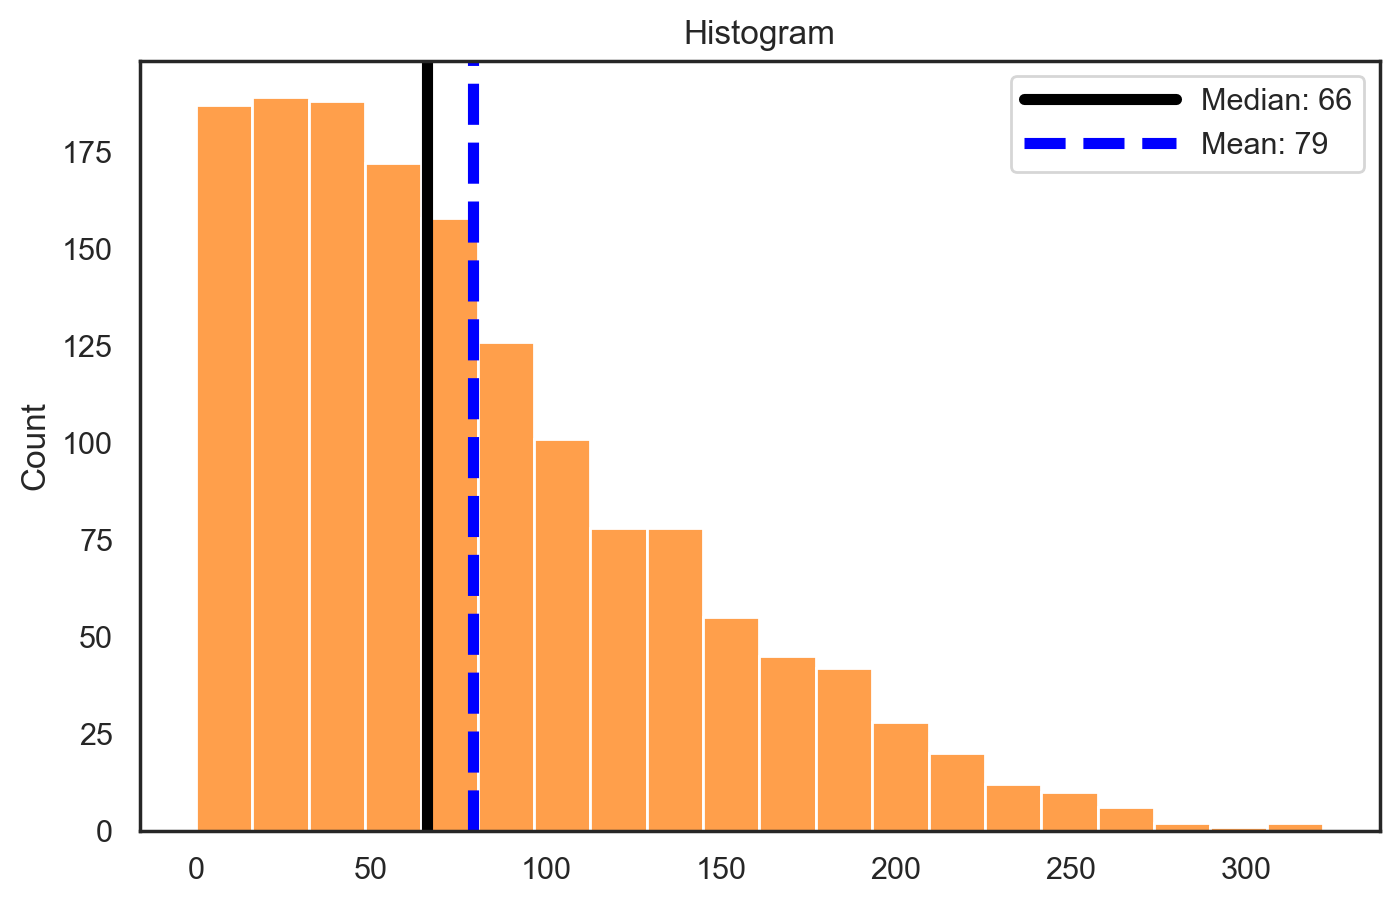

In [16]:
#####################
## You don't need to understand this code
#####################


skew_demo = np.round(skewnorm.rvs(180, size=1500, random_state=68410237)*100, 0).astype(int)

skew_md = np.median(skew_demo)
skew_mn = np.mean(skew_demo)

sns.set_theme(style="white", palette=None)

fig, ax = plt.subplots(figsize=(8,5))

sns.histplot(skew_demo, bins=20,
             ax=ax, color='tab:orange')

ax.axvline(skew_md, color='black', linewidth=4,
           label='Median: {}'.format(int(skew_md)))
ax.axvline(skew_mn, color='blue', linestyle='dashed', linewidth=4,
           label='Mean: {}'.format(int(skew_mn)))

ax.legend(handlelength=5)

ax.set_title("Histogram")
plt.show()

sns.set()

#note: we should use median because in this case the data is (left-)skewded. 
       #if we have a normal dist -> mean

#### What about non-numeric features?

In [17]:
# Check each step of these commands
modes = df_central[non_metric_features].mode().loc[0]
modes

education      Graduation
status            Married
gender                  M
dependents           True
description      OK nice!
Name: 0, dtype: object

### Exercise 2: Fill NaNs on df_central

In [25]:
# Fill NaNs on df_central
# CODE HERE
# complete the lines 

df_central[metric_features] = df_central[metric_features].fillna(medians)
df_central[non_metric_features] = df_central[non_metric_features].fillna(modes)

df_central.isna().sum(axis=0)

age                 0
income              0
frq                 0
rcn                 0
mnt                 0
clothes             0
kitchen             0
small_appliances    0
toys                0
house_keeping       0
dependents          0
per_net_purchase    0
gender              0
education           0
status              0
description         0
dtype: int64

## KNN imputer

Impute with KNN Imputer  
(using **2 neighbors**, **Manhattan distance**, and **uniform weights**)  

<div align="center">

| Sample | Feature 1 | Feature 2 |
|:------:|:----------:|:----------:|
|   A    |     2      |     10     |
|   B    |     4      |    NaN     |
|   C    |     6      |     30     |
|   D    |     7      |     40     |

</div>

In [26]:
# Creating new df copy to explore neighbordhood imputation
df_neighbors = df.copy()

In [27]:
# Seeing rows with NaNs
nans_index = df_neighbors.isna().any(axis=1)
nans_index

0       False
1       False
2       False
3        True
4       False
        ...  
8993    False
8994    False
8995    False
8996    False
8997    False
Length: 8998, dtype: bool

In [28]:
df_neighbors[nans_index]

,age,income,frq,rcn,mnt,clothes,kitchen,small_appliances,toys,house_keeping,dependents,per_net_purchase,gender,education,status,description
3,1955,93571.0,26,10,888,60,10,19,6,5,True,35,F,Master,NaN,OK nice!
61,1968,NaN,14,90,184,95,1,3,1,0,True,59,F,2nd Cycle,Married,Meh...
67,1981,60457.0,9,73,63,37,2,51,6,3,<NA>,57,M,PhD,Married,Meh...
70,1944,116259.0,28,35,1279,17,6,54,3,20,False,11,M,Graduation,NaN,OK nice!
73,1967,75274.0,16,67,263,88,3,6,1,2,<NA>,66,M,Graduation,Single,Kind of OK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8932,1959,NaN,20,71,716,67,5,25,3,1,False,27,M,Graduation,Married,Meh...
8942,1950,92746.0,34,98,1399,50,5,36,5,4,<NA>,28,M,Master,Married,Take my money!!
8964,1978,44661.0,6,49,33,18,18,35,16,13,True,42,M,1st Cycle,NaN,OK nice!
8972,1976,NaN,17,9,254,70,1,28,1,1,True,59,M,Graduation,Divorced,Meh...


### Exercise 3: Fill NaNs with KKNImputer

In [30]:
# KNNImputer - only works for numerical variables. Fill NaNs on df_neighbors
imputer = KNNImputer(n_neighbors=5, weights="uniform")
# CODE HERE
imputer.fit(df_neighbors[metric_features])
df_neighbors[metric_features] = imputer.transform(df_neighbors[metric_features])

In [31]:
# See rows with NaNs imputed
# CODE HERE 
df_neighbors[nans_index]

,age,income,frq,rcn,mnt,clothes,kitchen,small_appliances,toys,house_keeping,dependents,per_net_purchase,gender,education,status,description
3,1955.0,93571.0,26.0,10.0,888.0,60.0,10.0,19.0,6.0,5.0,True,35.0,F,Master,NaN,OK nice!
61,1968.0,63143.0,14.0,90.0,184.0,95.0,1.0,3.0,1.0,0.0,True,59.0,F,2nd Cycle,Married,Meh...
67,1981.0,60457.0,9.0,73.0,63.0,37.0,2.0,51.0,6.0,3.0,<NA>,57.0,M,PhD,Married,Meh...
70,1944.0,116259.0,28.0,35.0,1279.0,17.0,6.0,54.0,3.0,20.0,False,11.0,M,Graduation,NaN,OK nice!
73,1967.0,75274.0,16.0,67.0,263.0,88.0,3.0,6.0,1.0,2.0,<NA>,66.0,M,Graduation,Single,Kind of OK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8932,1959.0,85643.4,20.0,71.0,716.0,67.0,5.0,25.0,3.0,1.0,False,27.0,M,Graduation,Married,Meh...
8942,1950.0,92746.0,34.0,98.0,1399.0,50.0,5.0,36.0,5.0,4.0,<NA>,28.0,M,Master,Married,Take my money!!
8964,1978.0,44661.0,6.0,49.0,33.0,18.0,18.0,35.0,16.0,13.0,True,42.0,M,1st Cycle,NaN,OK nice!
8972,1976.0,63932.4,17.0,9.0,254.0,70.0,1.0,28.0,1.0,1.0,True,59.0,M,Graduation,Divorced,Meh...


#### Keep central tendency imputation

*Why?*

In [32]:
# let's keep the central imputation
df = df_central.copy()

## An overview of our previous data exploration

You can also explore this dataset using the exported `pandas-profiling` report.




![](https://raw.githubusercontent.com/fpontejos/Data-Mining-24-25/refs/heads/main/figures/eda/categorical_variables_counts.png)

![](https://raw.githubusercontent.com/fpontejos/Data-Mining-24-25/refs/heads/main/figures/eda/numeric_variables_histograms.png)

![](https://raw.githubusercontent.com/fpontejos/Data-Mining-24-25/refs/heads/main/figures/eda/numeric_variables_boxplots.png)

![](https://raw.githubusercontent.com/fpontejos/Data-Mining-24-25/refs/heads/main/figures/eda/pairwise_numeric_scatterplots.png)

![](https://raw.githubusercontent.com/fpontejos/Data-Mining-24-25/refs/heads/main/figures/eda/correlation_matrix.png)

# Outlier removal

Why do we need to remove outliers? Which methods can we use?




### Outlier removal using only the IQR method

Why should you use/not use this method?

Inter-Quartile Range formula:

<br>

$IQR = Q_3 – Q_1$

<br>

---

<br>

**Outliers** are the observations that fall
- below $Q_1 − 1.5 \times IQR$

or

- above $Q_3 + 1.5 \times IQR$

<br>
<br>

https://online.stat.psu.edu/stat200/lesson/3/3.2

#### Exercise 4: Compute the Q1, Q3, IQR, upper and lower outliers bound  

In [33]:
# Compute the IQR
# HINT: Use .quantile()

# Calculate Q1, Q3, IQR

q1 = df[metric_features].quantile(0.25)
q1


age                  1951.00
income              47892.75
frq                    10.00
rcn                    26.00
mnt                    63.00
clothes                33.00
kitchen                 2.00
small_appliances       19.00
toys                    2.00
house_keeping           2.00
per_net_purchase       28.00
Name: 0.25, dtype: float64

In [34]:
# Calculate Q1, Q3, IQR

q3 = df[metric_features].quantile(0.75)
q3


age                  1981.0
income              92129.5
frq                    28.0
rcn                    79.0
mnt                  1076.0
clothes                69.0
kitchen                10.0
small_appliances       37.0
toys                   10.0
house_keeping           9.0
per_net_purchase       57.0
Name: 0.75, dtype: float64

In [35]:
# Calculate Q1, Q3, IQR

iqr = q3-q1
iqr

age                    30.00
income              44236.75
frq                    18.00
rcn                    53.00
mnt                  1013.00
clothes                36.00
kitchen                 8.00
small_appliances       18.00
toys                    8.00
house_keeping           7.00
per_net_purchase       29.00
dtype: float64

In [39]:
# Compute upper and lower limit 

lower_lim = q1-(1.5*iqr)
lower_lim

age                  1906.000
income             -18462.375
frq                   -17.000
rcn                   -53.500
mnt                 -1456.500
clothes               -21.000
kitchen               -10.000
small_appliances       -8.000
toys                  -10.000
house_keeping          -8.500
per_net_purchase      -15.500
dtype: float64

In [40]:
upper_lim = q3+(1.5*iqr)
upper_lim

age                   2026.000
income              158484.625
frq                     55.000
rcn                    158.500
mnt                   2595.500
clothes                123.000
kitchen                 22.000
small_appliances        64.000
toys                    22.000
house_keeping           19.500
per_net_purchase       100.500
dtype: float64

In [41]:
filters_iqr_all = df[metric_features].apply(
    lambda col: col.between(lower_lim[col.name], upper_lim[col.name], inclusive='neither')).all(axis=1)

In [43]:
filters_iqr_all

0        True
1        True
2       False
3        True
4        True
        ...  
8993     True
8994     True
8995     True
8996     True
8997    False
Length: 8998, dtype: bool

In [44]:
# Lets break this out

df["age"].between(1950, 1990, inclusive='neither')

0       False
1       False
2       False
3        True
4        True
        ...  
8993     True
8994     True
8995     True
8996    False
8997    False
Name: age, Length: 8998, dtype: bool

In [45]:
df[metric_features].apply(
    lambda col: col.between(lower_lim[col.name], upper_lim[col.name], inclusive='neither'))

,age,income,frq,rcn,mnt,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase
0,True,True,True,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True,True,False,True
3,True,True,True,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...
8993,True,True,True,True,True,True,True,True,True,True,True
8994,True,True,True,True,True,True,True,True,True,True,True
8995,True,True,True,True,True,True,True,True,True,True,True
8996,True,True,True,True,True,True,True,True,True,True,True


In [46]:
df[metric_features].apply(
    lambda col: col.between(lower_lim[col.name], upper_lim[col.name], inclusive='neither')).all(axis=1)

0        True
1        True
2       False
3        True
4        True
        ...  
8993     True
8994     True
8995     True
8996     True
8997    False
Length: 8998, dtype: bool

In [47]:
filters_iqr_all

0        True
1        True
2       False
3        True
4        True
        ...  
8993     True
8994     True
8995     True
8996     True
8997    False
Length: 8998, dtype: bool

In [48]:
df_iqr = df[filters_iqr_all]

print('Percentage of data kept after removing outliers:', 100*(np.round(df_iqr.shape[0] / df_original.shape[0], 4)))


Percentage of data kept after removing outliers: 81.56


What do you think of this number?

In general we want to keep as much of our data as possible.

As a rule of thumb, try not to remove more than 5% of your rows. 

***This is only a rule of thumb!*** 

In some cases it really is necessary to remove more.


### Manual outlier removal

Now let's try "manually" filtering the dataset's outliers

---


Let's look at the boxplots again:

![](https://raw.githubusercontent.com/fpontejos/Data-Mining-24-25/refs/heads/main/figures/eda/numeric_variables_boxplots.png)

![](https://raw.githubusercontent.com/fpontejos/Data-Mining-24-25/refs/heads/main/figures/eda/categorical_variables_counts.png)

### Exercise 5: Set manually the bounds for outliers  

In [52]:
# This may vary from session to session, and is prone to varying interpretations.
# A simple example is provided below:

# ( df['feature1']<= limit1 ) & ( df['feature2']<= limit2 ) ...


filters_man = (
    # CODE HERE
    #   ( df['feature1']<= limit1 ) 
    # & ( df['feature2']<= limit2 )
    # ...
    # replace this
    (df['house_keeping']<= 40 ) 
    &
    # replace this
    (df['kitchen']<= 40 ) 
    &
    # replace this
    (df['toys']<= 40 ) 
    &
    # replace this
    (df['education']!='Oldschool')
    &
    (df['status'] != 'Whatever')
    &
    (df['rcn'] <= 300)

)

df_man = df[filters_man]

In [53]:
# Let's break this out

filters_man

0        True
1        True
2        True
3        True
4        True
        ...  
8993     True
8994     True
8995     True
8996     True
8997    False
Length: 8998, dtype: bool

In [54]:
print('Percentage of data kept after removing outliers:', np.round(df_man.shape[0] / df_original.shape[0], 4))

Percentage of data kept after removing outliers: 0.9588


## Combining different outlier methods

More robust/ consistent outlier detection method:

In [55]:
## What is this doing?
df_out = df[(filters_iqr_all | filters_man)] 


print('Percentage of data kept after removing outliers:', np.round(df_out.shape[0] / df_original.shape[0], 4))

Percentage of data kept after removing outliers: 0.9602


In [57]:
# Get the manual filtering version

df = df_man.copy()



## Outlier threshold value

You may change the values of observations for a given variable:


In [58]:
# Remember the 'rcn' variable had an odd behavior? 
# This is the time to fix that

# CODE HERE

In [59]:
print((df['rcn']>100).value_counts())

rcn_t = df['rcn'].copy()
rcn_t.loc[rcn_t>100] = 100

df['rcn'] = rcn_t

rcn
False    8455
True      172
Name: count, dtype: int64


### Visualize your boxplots after outlier removal.


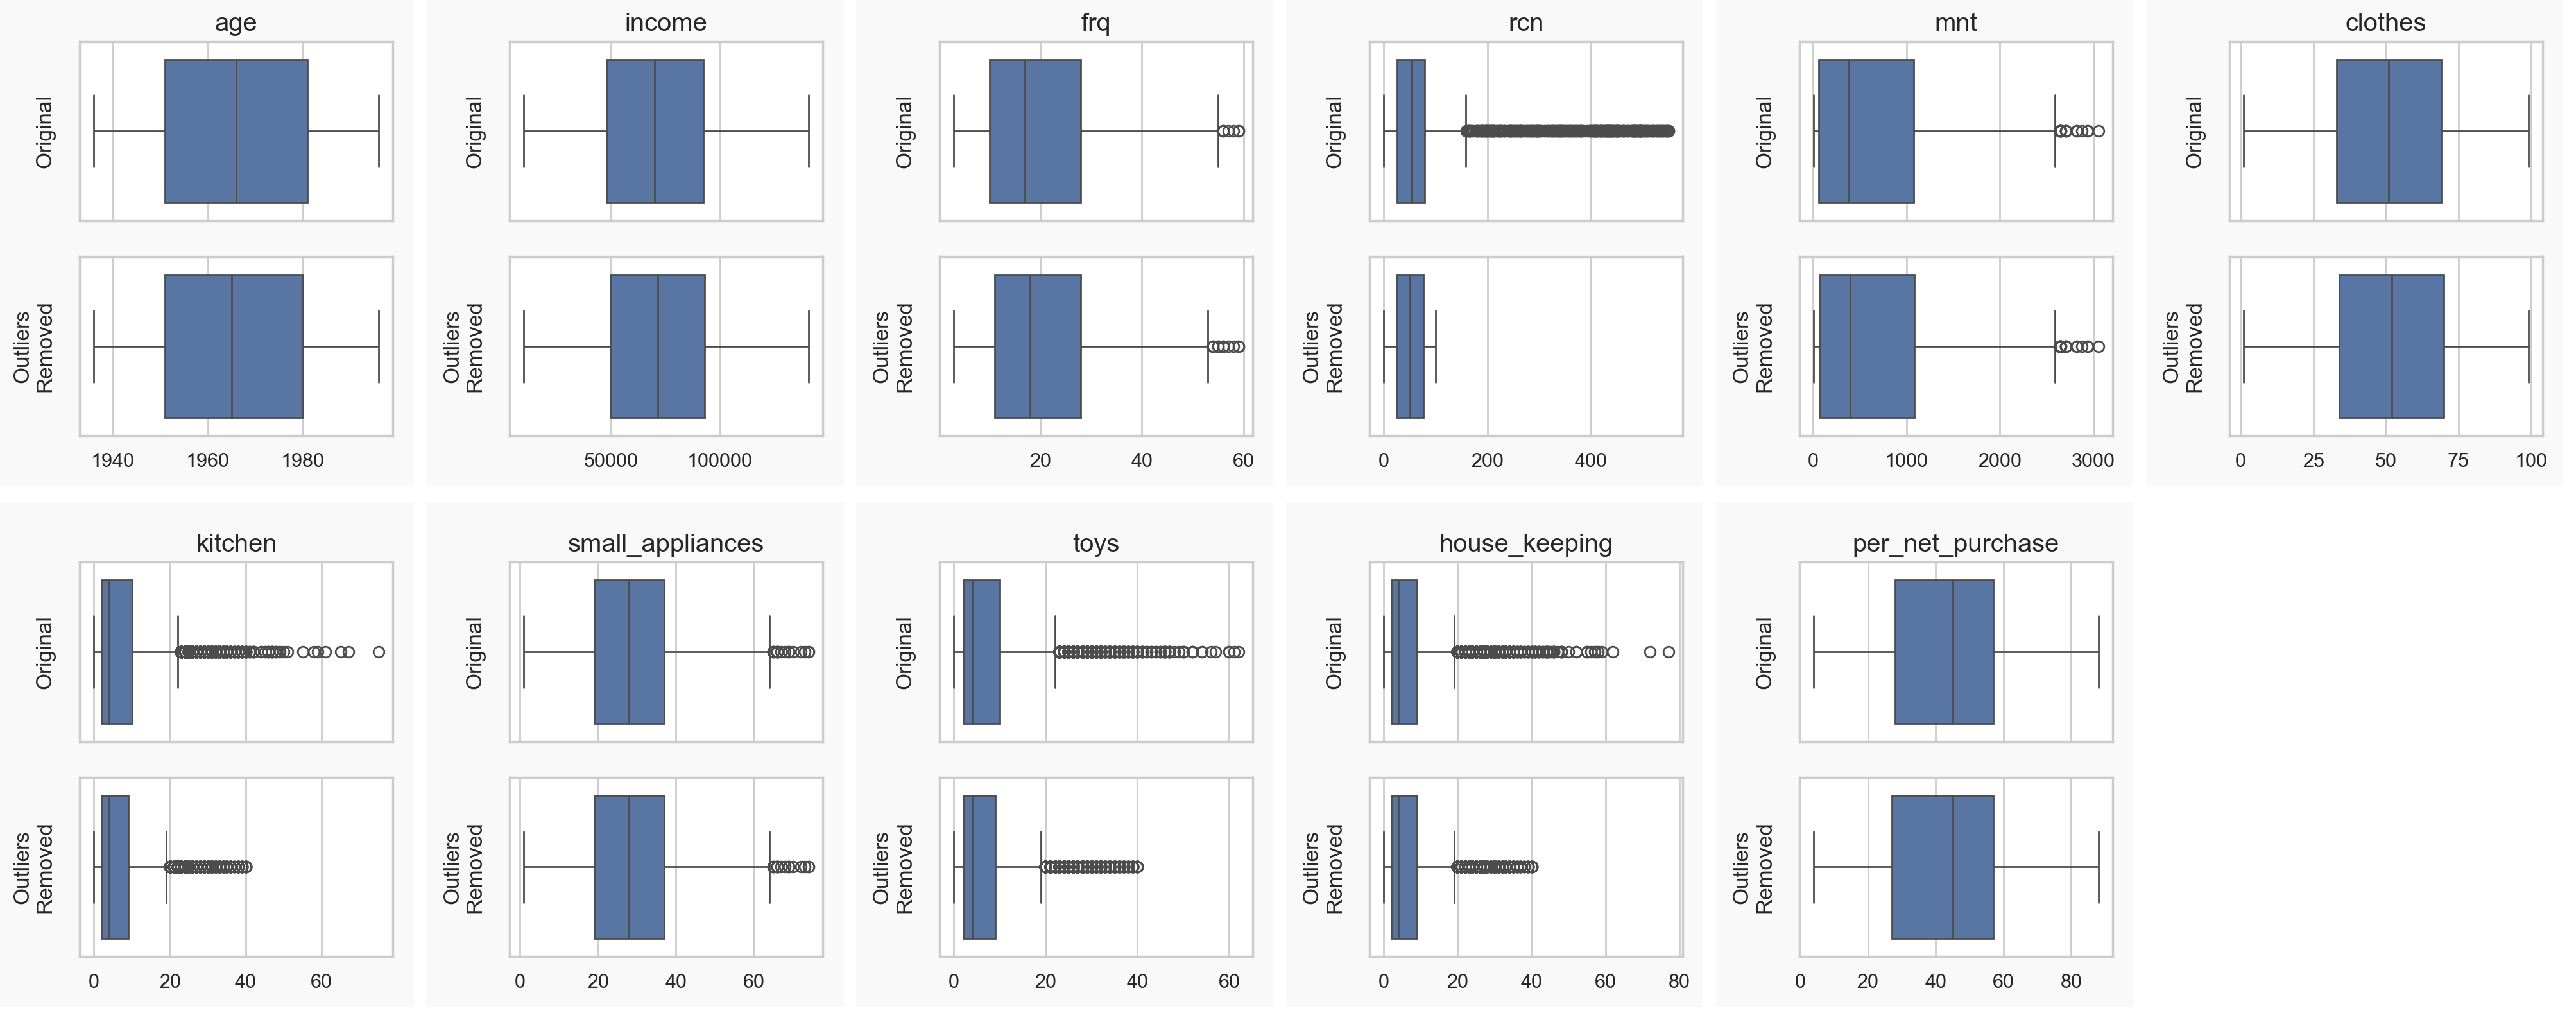

In [60]:
# CODE HERE
sns.set_style('whitegrid')

fig = plt.figure(figsize=(20,8))
subfigs = fig.subfigures(
    2, 
    ceil(len(metric_features)/2), 
    wspace=.03, hspace=.03)


for sfig, feat in zip(subfigs.flatten(), metric_features):
    axes = sfig.subplots(2, 1, sharex=True)
    
    sns.boxplot(x=df_original[feat], ax=axes[0])
    axes[0].set_ylabel('Original')
    axes[0].set_title(feat, fontsize='large')
    
    
    sns.boxplot(x=df[feat], ax=axes[1])
    axes[1].set_ylabel('Outliers\nRemoved')
    axes[1].set_xlabel('')

    # Subfigure Aesthetics
    sfig.set_facecolor("#F9F9F9")
    sfig.subplots_adjust(left=.2, right=.95, bottom=.1,)

    
# plt.savefig(os.path.join('..', 'figures', 'eda', 'boxplots_before_after_outliers.png'), dpi=200)
plt.show()


sns.set()

In [61]:
# Figure
#  ├── SubFigure 1
#  │    ├── Axes 1
#  │    └── Axes 2
#  └── SubFigure 2
#       ├── Axes 3
#       └── Axes 4

# Feature Engineering

**Feature engineering** is the process of creating new input features from existing data to improve model performance or enhance insight.


A reminder of our metadata:
- *id* - The unique identifier of the customer
- *age* - The year of birht of the customer
- *income* - The income of the customer
- *frq* - Frequency: number of purchases made by the customer
- *rcn* - Recency: number of days since last customer purchase
- *mnt* - Monetary: amount of € spent by the customer in purchases
- *clothes* - Number of clothes items purchased by the customer
- *kitchen* - Number of kitchen items purchased by the customer
- *small_appliances* - Number of small_appliances items purchased by the customer
- *toys* - Number of toys items purchased by the customer
- *house_keeping* - Number of house_keeping items purchased by the customer
- *dependents* - Binary. Whether or not the customer has dependents
- *per_net_purchase* - Percentage of purchases made online
- *education* - Education level of the customer
- *status* - Marital status of the customer
- *gender* - Gender of the customer
- *description* - Last customer's recommendation description

### Exercise 6: Rename `age` to `YoB`. Create the features `age` and `spent_online`

In [62]:
# Try to pull as many features as you can; You can always drop them later on
# You can start by converting the 'age' variable to the actual age
# You can also store the birth year in another feature

# CODE HERE
df.rename(columns={'age': 'YoB'}, inplace=True)


In [63]:
df

,YoB,income,frq,rcn,mnt,clothes,kitchen,small_appliances,toys,house_keeping,dependents,per_net_purchase,gender,education,status,description
0,1946,90782.0,33,66,1402,37,5,44,10,3,False,19,M,Graduation,Together,Take my money!!
1,1936,113023.0,32,6,1537,55,1,38,4,2,False,9,F,PhD,Divorced,Take my money!!
2,1990,28344.0,11,69,44,32,19,24,1,24,True,59,M,Graduation,Married,Kind of OK
3,1955,93571.0,26,10,888,60,10,19,6,5,True,35,F,Master,Married,OK nice!
4,1955,91852.0,31,26,1138,59,5,28,4,4,True,34,F,Graduation,Together,Take my money!!
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8992,1954,87399.0,25,1,837,56,8,27,8,1,True,47,M,Graduation,Married,Kind of OK
8993,1960,94367.0,28,1,896,68,5,21,3,4,True,55,F,1st Cycle,Single,Take my money!!
8994,1975,58121.0,12,6,61,53,6,28,7,6,True,71,M,2nd Cycle,Single,Meh...
8995,1986,54292.0,29,72,1011,41,11,36,1,11,False,31,M,Graduation,Together,Take my money!!


In [65]:
df['age'] = 2025-df["YoB"]
df

,YoB,income,frq,rcn,mnt,clothes,kitchen,small_appliances,toys,house_keeping,dependents,per_net_purchase,gender,education,status,description,age
0,1946,90782.0,33,66,1402,37,5,44,10,3,False,19,M,Graduation,Together,Take my money!!,79
1,1936,113023.0,32,6,1537,55,1,38,4,2,False,9,F,PhD,Divorced,Take my money!!,89
2,1990,28344.0,11,69,44,32,19,24,1,24,True,59,M,Graduation,Married,Kind of OK,35
3,1955,93571.0,26,10,888,60,10,19,6,5,True,35,F,Master,Married,OK nice!,70
4,1955,91852.0,31,26,1138,59,5,28,4,4,True,34,F,Graduation,Together,Take my money!!,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8992,1954,87399.0,25,1,837,56,8,27,8,1,True,47,M,Graduation,Married,Kind of OK,71
8993,1960,94367.0,28,1,896,68,5,21,3,4,True,55,F,1st Cycle,Single,Take my money!!,65
8994,1975,58121.0,12,6,61,53,6,28,7,6,True,71,M,2nd Cycle,Single,Meh...,50
8995,1986,54292.0,29,72,1011,41,11,36,1,11,False,31,M,Graduation,Together,Take my money!!,39


In [66]:
df['spent_online'] = df['mnt'] * df['per_net_purchase']/100
df

,YoB,income,frq,rcn,mnt,clothes,kitchen,small_appliances,toys,house_keeping,dependents,per_net_purchase,gender,education,status,description,age,spent_online
0,1946,90782.0,33,66,1402,37,5,44,10,3,False,19,M,Graduation,Together,Take my money!!,79,266.38
1,1936,113023.0,32,6,1537,55,1,38,4,2,False,9,F,PhD,Divorced,Take my money!!,89,138.33
2,1990,28344.0,11,69,44,32,19,24,1,24,True,59,M,Graduation,Married,Kind of OK,35,25.96
3,1955,93571.0,26,10,888,60,10,19,6,5,True,35,F,Master,Married,OK nice!,70,310.80
4,1955,91852.0,31,26,1138,59,5,28,4,4,True,34,F,Graduation,Together,Take my money!!,70,386.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8992,1954,87399.0,25,1,837,56,8,27,8,1,True,47,M,Graduation,Married,Kind of OK,71,393.39
8993,1960,94367.0,28,1,896,68,5,21,3,4,True,55,F,1st Cycle,Single,Take my money!!,65,492.80
8994,1975,58121.0,12,6,61,53,6,28,7,6,True,71,M,2nd Cycle,Single,Meh...,50,43.31
8995,1986,54292.0,29,72,1011,41,11,36,1,11,False,31,M,Graduation,Together,Take my money!!,39,313.41


In [67]:
# ONLY RUN THIS CELL ONCE 

metric_features.append('spent_online')
metric_features.append('YoB')

# Variable selection: Redundancy VS Relevancy

### Redundancy: Handling highly correlated variables

We already saw our original correlation matrix:

![](https://raw.githubusercontent.com/fpontejos/Data-Mining-24-25/refs/heads/main/figures/eda/correlation_matrix.png)


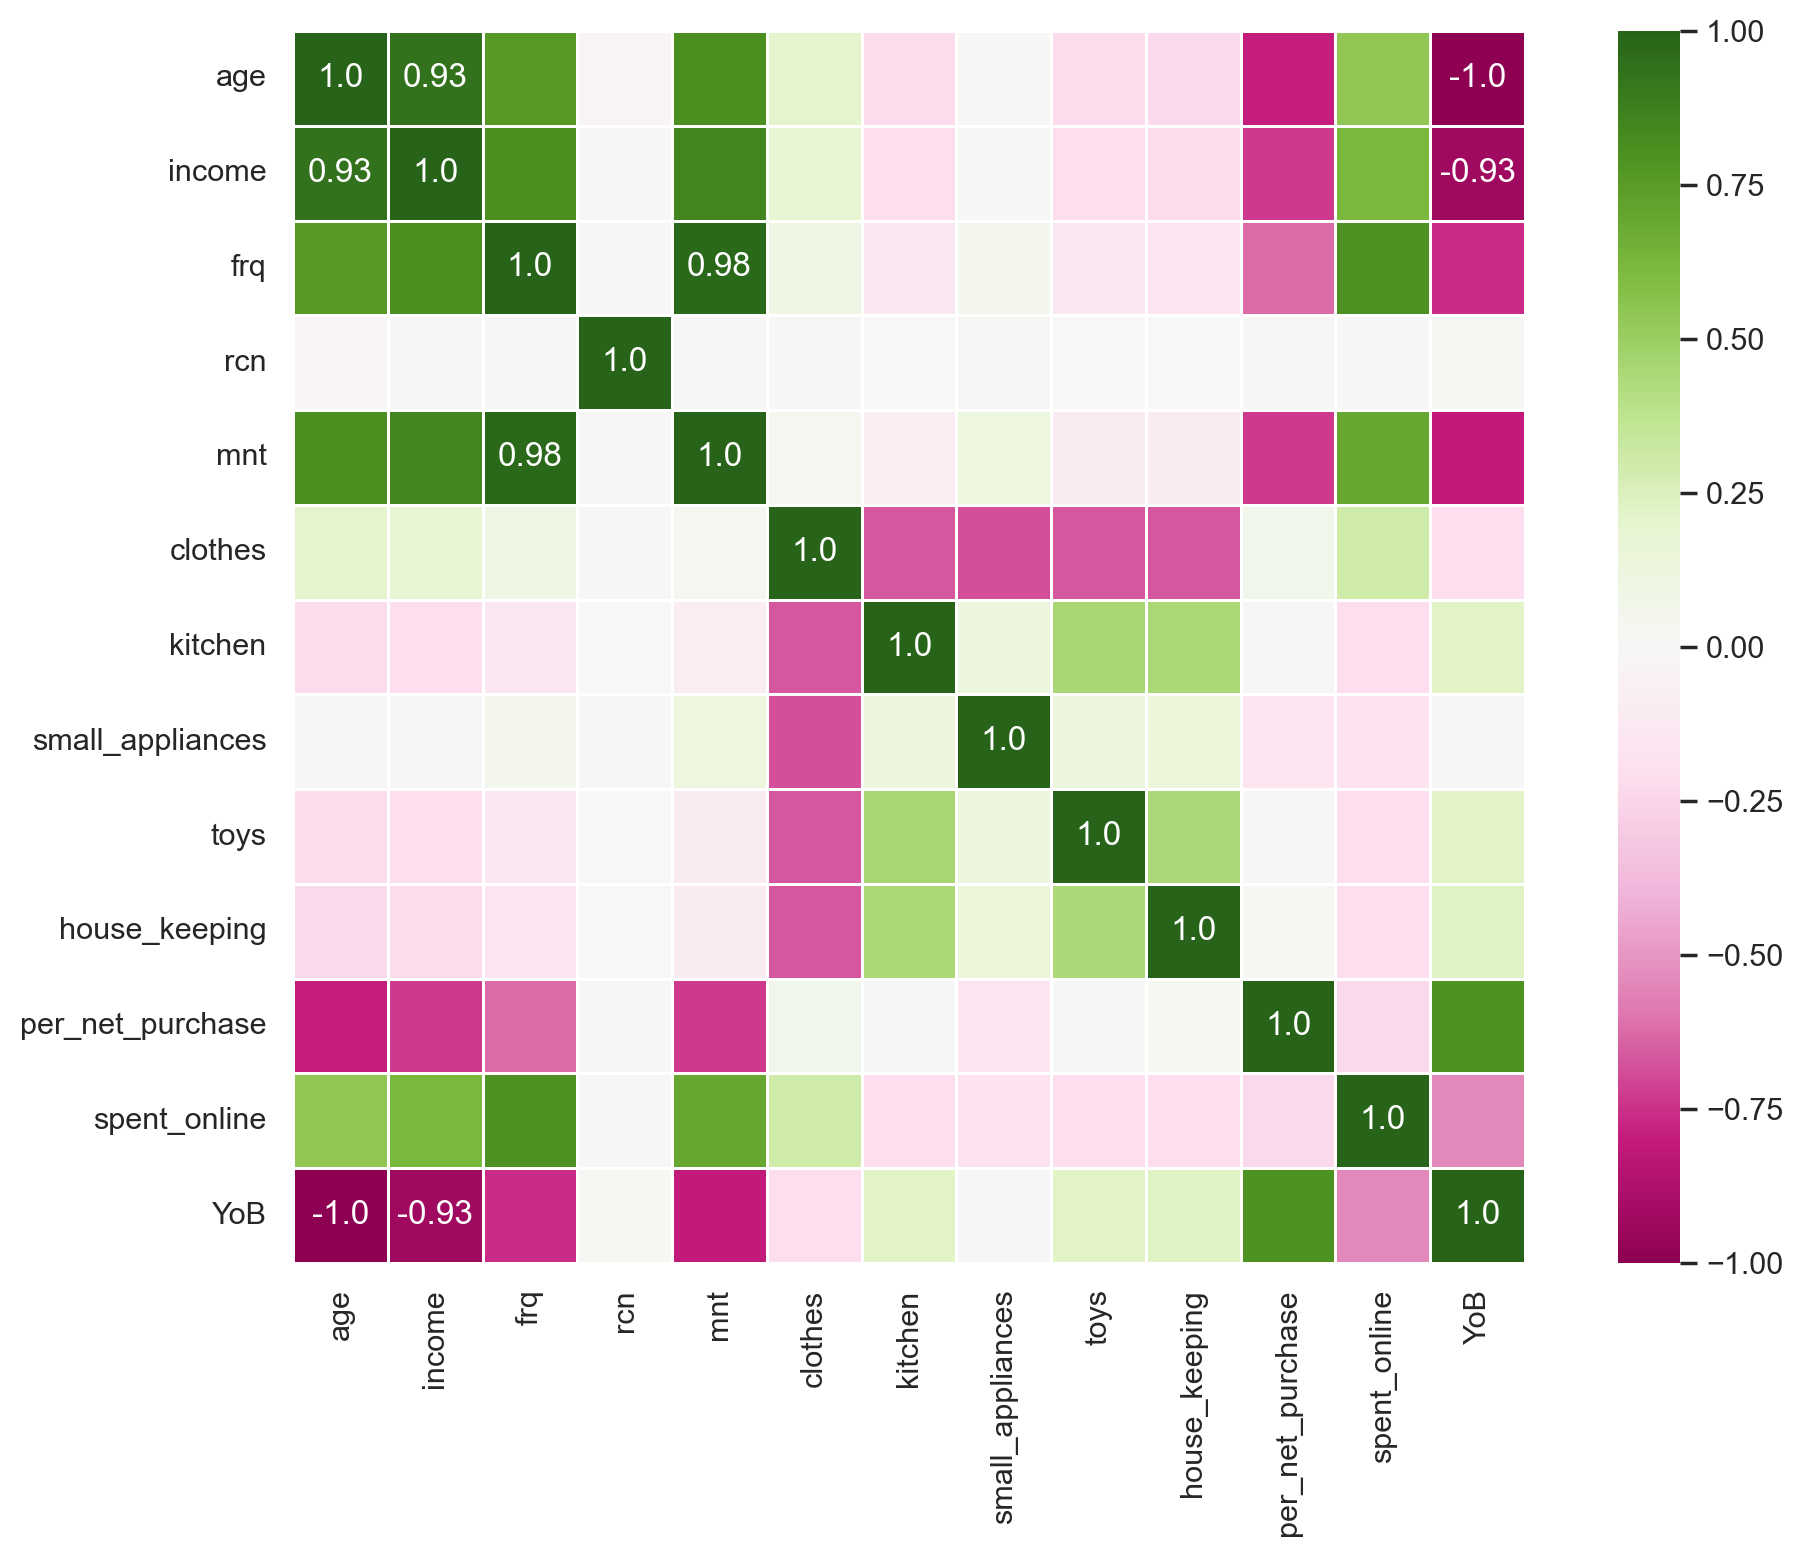

In [68]:
plt.figure(figsize=(12,8))
corr = df[metric_features].corr()
corr = corr.round(2)

sns.heatmap(
    corr,
    center = 0,
    cmap='PiYG',
    annot=np.where(np.absolute(corr) >= 0.9, corr.values, np.full(corr.values.shape, "")),
    fmt='s',
    square=True,
    linewidths=.5,
)
plt.show()

### Exercise 7:  Modify the list `metric_features` to exclude redundant features 

In [69]:
# Select variables according to their correlations
# Updating metric_features
## RUN THIS CELL ONLY ONCE!!!!

# CODE HERE
metric_features.remove("income")
metric_features.remove("YoB")
metric_features.remove("mnt")

In [70]:
metric_features

['age',
 'frq',
 'rcn',
 'clothes',
 'kitchen',
 'small_appliances',
 'toys',
 'house_keeping',
 'per_net_purchase',
 'spent_online']

In [50]:
# You can also drop the features from the df
# But sometimes they may be useful for cluster profiling later

# df.drop(..., inplace=True)


### Relevancy
Selecting variables based on the relevancy of each one to the task. 

Example: 
- remove uncorrelated variables with the target,
- stepwise regression,
- use variables for product clustering,
- use variables for socio-demographic clustering,
- ...

Variables that aren't correlated with any other variable are often also not relevant. In this case we will not focus on this a lot since we don't have a defined task yet.

# Redo data exploration

Check if the data looks the way you expect it to. 

- Have you missed some outliers? 
- Are there still missing values?
- Is the data normalized?

This is an iterative process. It is likely you will change your preprocessing steps frequently throughout your group work.

#### A tool to assist you through your exploratory data analysis

Optionally, you may use `pandas-profiling` in your data analysis. 

Remember, although this tool provides excelent insights about the data you're working with, it is not enough to perform a proper analysis.

In [51]:
# ProfileReport(
#     df,
#     title='Tugas Customer Data Preprocessed',
#     correlations={
#         "pearson": {"calculate": True},
#         "spearman": {"calculate": False},
#         "kendall": {"calculate": False},
#         "phi_k": {"calculate": False},
#         "cramers": {"calculate": False},
#     },
# )